In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import warnings
warnings.filterwarnings("ignore")

In [3]:
# read the dataset
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

In [4]:
# print shape of datasets
print('Shape of the train dataset : ', train_data.shape)
print('Shape of the test dataset : ', test_data.shape)

Shape of the train dataset :  (262144, 258)
Shape of the test dataset :  (131073, 257)


#### First things first, Let's handle the missing values from dataset.

In [5]:
# let's check that if there is missing values in the dataset
print('Missing Values in Train Dataset : ', train_data.isnull().sum().sum())
print('Missing Values in Test Dataset : ', test_data.isnull().sum().sum())

Missing Values in Train Dataset :  0
Missing Values in Test Dataset :  0


#### Distribution Of Classes In Label Column

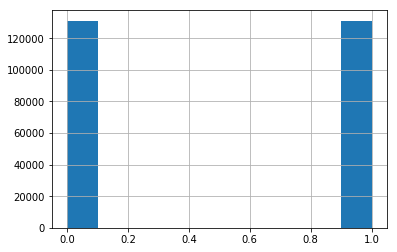

In [6]:
train_data.target.hist()

From the graph it is clear that there is no class imbalance problem.

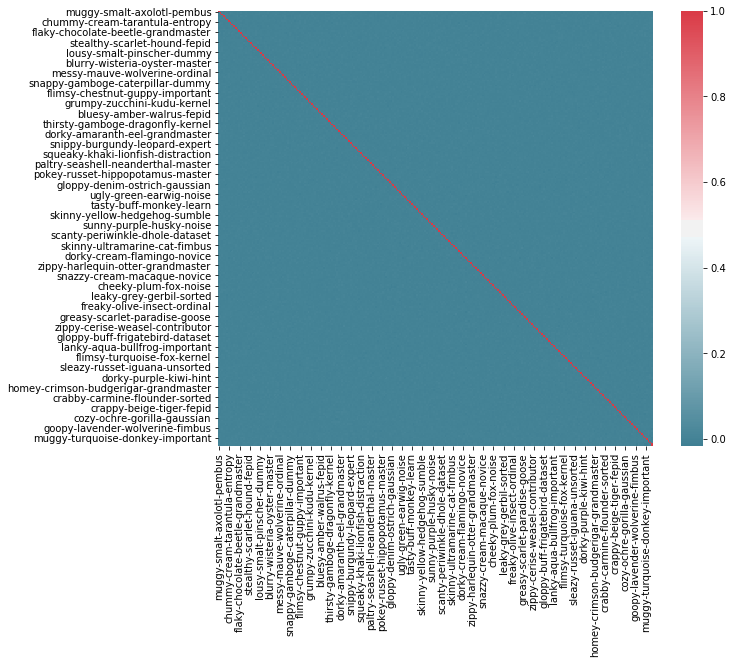

In [7]:
# There are 258 attributes in the train dataset, which is infact not desirable
# we need to select only a subset of columns (dimensionality reduction)
# for that let's check that if there strong correlation exist between them
f, ax = plt.subplots(figsize=(10, 8))
corr = train_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [8]:
# handlng the categorical features
train_data.select_dtypes(exclude=["number","bool_","object_"]).columns

Index([], dtype='object')

In [9]:
labels = train_data['target']
train_data = train_data.drop(['id','target'], axis=1)

Which shows that there is no correlation at all. Hmm, so what are the hidden patterns that I'm looking at!


### Logistic Regression

In [10]:
# let us try a logistic regression model on the dataset

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, labels, test_size = 0.25, random_state = 0)

In [11]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[16931, 15920],
       [15314, 17371]])

In [14]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC for LR =',round(auc,5))

ROC AUC for LR = 0.52343


It is ~ 0.5, which says the model will predict an ouput with 50% confidence. <br>
Infact a random value generator can perform better than this. <br>
Which shows that this is the worst case that can happen. <br>
Why do we get such a kind of result ? Does it have anything to do with the results of the correlation matrix ?

#### Step back and Start again

In [15]:
train_data['target'] = labels


In [16]:
# the medians of columns when we group the data by 'target' feature
target_medians = train_data.groupby("target").median()
target_medians

,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.003830,0.005895,-0.005381,0.00142,-0.001147,0.002574,0.000173,-0.002225,0.004538,0.001990,0.002689,0.003768,0.002174,0.010786,0.006374,-0.002862,0.003366,0.000804,0.001918,-0.004326,0.002381,-0.008473,0.001558,0.003107,-0.001678,-0.004184,-0.000022,0.002585,0.000524,0.002913,0.002978,-0.002891,-0.004892,-0.000762,0.001352,-0.006793,-0.009537,0.002001,0.004336,-0.001682,...,-0.003281,-0.000642,0.004498,0.004535,0.002211,0.005848,0.001274,-0.008567,0.003951,0.005135,-0.002266,0.002958,-0.006492,-0.002099,-0.003505,0.003432,-0.003185,-0.000391,-0.002449,0.001823,0.007564,0.002513,0.006448,0.005095,0.005051,0.007239,0.003739,-0.001551,-0.001887,0.001487,-0.008059,0.009265,-0.010097,0.000491,-0.001523,-0.000801,0.005334,-0.000179,-0.005035,-0.008936
1,0.007939,0.001139,-0.006229,-0.00886,0.002757,0.003109,0.002431,-0.005044,0.005471,0.006755,-0.002244,0.003921,-0.004075,-0.003980,0.006961,-0.004193,0.004510,-0.001569,-0.004439,-0.007139,-0.007310,0.000068,0.009445,-0.013049,-0.001008,-0.002276,-0.004785,0.000410,0.009148,-0.007046,0.001172,-0.000698,-0.002656,0.002888,-0.002123,-0.000507,-0.000251,0.010998,-0.001572,-0.005971,...,0.002655,0.002374,-0.009205,-0.000092,-0.001265,0.003617,0.001590,-0.009932,0.003596,0.008068,-0.009159,-0.000724,-0.003008,0.008151,-0.002555,-0.001117,0.013949,-0.002149,0.001985,-0.001607,0.012546,0.005629,0.008072,-0.000918,-0.001888,-0.003810,-0.001474,-0.005438,0.000518,-0.004332,-0.006571,-0.013559,0.001838,-0.001791,0.003424,0.000192,-0.006750,-0.011512,-0.003874,-0.000340

In [17]:
# let's calculate the difference b/w row-1 and row-2
sorted_target_distance = np.abs(target_medians.iloc[0]-target_medians.iloc[1]).sort_values(ascending=False)

In [18]:
sorted_target_distance.head() # they do posses large difference b/w the medians

wheezy-myrtle-mandrill-entropy       0.022824
skanky-carmine-rabbit-contributor    0.018644
thirsty-carmine-corgi-ordinal        0.017134
stinky-olive-kiwi-golden             0.016771
dorky-turquoise-maltese-important    0.016333
dtype: float64

In [19]:
sorted_target_distance.tail()

shaggy-silver-indri-fimbus            0.000153
gloppy-mauve-bonobo-important         0.000138
muggy-pumpkin-scorpion-grandmaster    0.000127
craggy-maroon-civet-grandmaster       0.000107
wheezy-copper-turtle-magic            0.000000
dtype: float64

Zero! What's happening here?

To understand the effect of these distribution let us comapare the 2nd attribute and last one to the attribute in 1st solution.

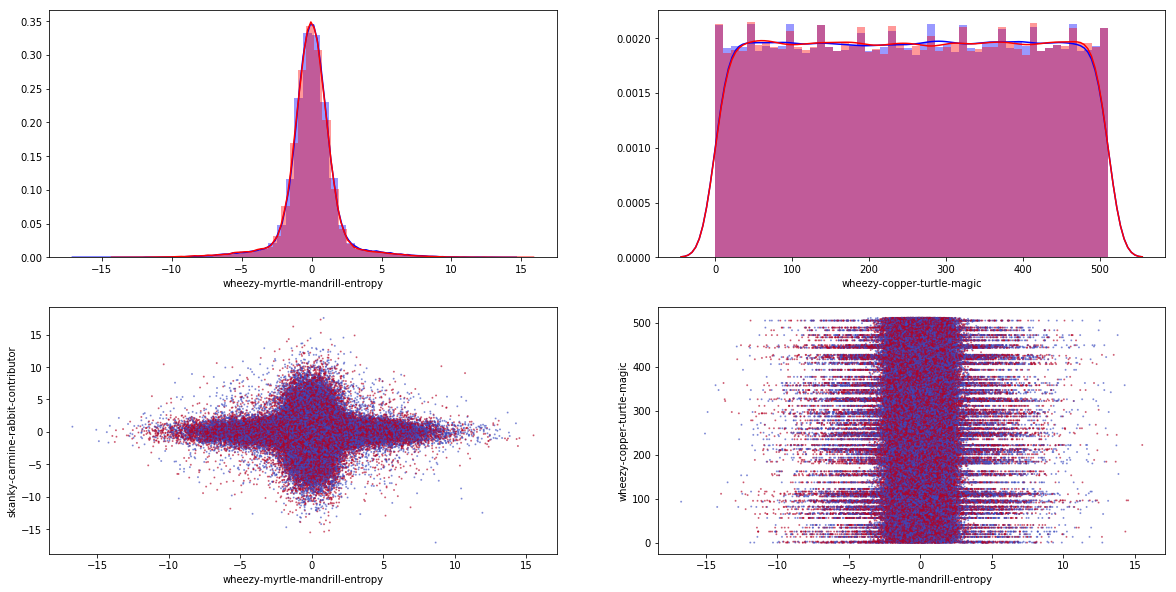

In [20]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
sns.distplot(train_data.loc[train_data.target==0, "wheezy-myrtle-mandrill-entropy"], color="Blue", ax=ax[0,0])
sns.distplot(train_data.loc[train_data.target==1, "wheezy-myrtle-mandrill-entropy"], color="Red", ax=ax[0,0])
sns.distplot(train_data.loc[train_data.target==0, "wheezy-copper-turtle-magic"], color="Blue", ax=ax[0,1])
sns.distplot(train_data.loc[train_data.target==1, "wheezy-copper-turtle-magic"], color="Red", ax=ax[0,1])
ax[1,0].scatter(train_data["wheezy-myrtle-mandrill-entropy"].values,
                train_data["skanky-carmine-rabbit-contributor"].values, c=train_data.target.values,
                cmap="coolwarm", s=1, alpha=0.5)
ax[1,0].set_xlabel("wheezy-myrtle-mandrill-entropy")
ax[1,0].set_ylabel("skanky-carmine-rabbit-contributor")
ax[1,1].scatter(train_data["wheezy-myrtle-mandrill-entropy"].values,
                train_data["wheezy-copper-turtle-magic"].values, c=train_data.target.values,
                cmap="coolwarm", s=1, alpha=0.5)
ax[1,1].set_xlabel("wheezy-myrtle-mandrill-entropy")
ax[1,1].set_ylabel("wheezy-copper-turtle-magic");

The 2nd and 4th graph shows that the distribution of <b>wheezy-copper-turtle-magic</b> is spread across the space around it.

### The effect of 'wheezy-copper-turtle-magic'

In [21]:
# consider the distribution of first three attributes from above list

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

feat1 = "wheezy-myrtle-mandrill-entropy"
feat2 = "skanky-carmine-rabbit-contributor"
feat3 = "thirsty-carmine-corgi-ordinal"

N = 10000

trace1 = go.Scatter3d(
    x=train_data[feat1].values[0:N], 
    y=train_data[feat2].values[0:N],
    z=train_data[feat3].values[0:N],
    mode='markers',
    marker=dict(
        color=train_data.target.values[0:N],
        colorscale = "Jet",
        opacity=0.3,
        size=2
    )
)

figure_data = [trace1]
layout = go.Layout(
    title = 'The turtle place',
    scene = dict(
        xaxis = dict(title=feat1),
        yaxis = dict(title=feat2),
        zaxis = dict(title=feat3),
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    showlegend=True
)

fig = go.Figure(data=figure_data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [22]:
# consider the distribution of first two attributes and the last one 'wheezy-copper-turtle-magic' from above list

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

feat1 = "wheezy-myrtle-mandrill-entropy"
feat2 = "skanky-carmine-rabbit-contributor"
feat3 = "wheezy-copper-turtle-magic"

N = 10000

trace1 = go.Scatter3d(
    x=train_data[feat1].values[0:N], 
    y=train_data[feat2].values[0:N],
    z=train_data[feat3].values[0:N],
    mode='markers',
    marker=dict(
        color=train_data.target.values[0:N],
        colorscale = "Jet",
        opacity=0.3,
        size=2
    )
)

figure_data = [trace1]
layout = go.Layout(
    title = 'The turtle place',
    scene = dict(
        xaxis = dict(title=feat1),
        yaxis = dict(title=feat2),
        zaxis = dict(title=feat3),
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    showlegend=True
)

fig = go.Figure(data=figure_data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

Previous LR model does not consider the interactions between the attributes. It treats the attributes as Independant Variables. <br> So we need to create an LR model by considering the interactions.

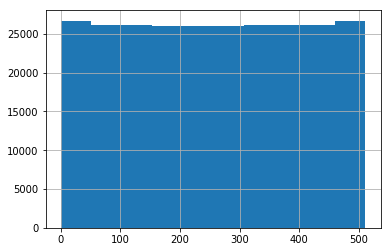

In [23]:
# let's check the distribution of 'wheezy-copper-turtle-magic'
train_data['wheezy-copper-turtle-magic'].hist()

In [24]:
train_data['wheezy-copper-turtle-magic'].describe()

count    262144.000000
mean        255.602486
std         147.920785
min           0.000000
25%         127.000000
50%         256.000000
75%         384.000000
max         511.000000
Name: wheezy-copper-turtle-magic, dtype: float64

The distribution of <b>wheezy-copper-turtle-magic</b> is between (0, 512)

### Logistic Regression With Interactions

We will create seperate 512 model for the unique values of the <b>wheezy-copper-turtle-magic</b>

In [25]:
# INITIALIZE VARIABLES
cols = [c for c in train_data.columns if c not in ['id', 'target']]
cols.remove('wheezy-copper-turtle-magic')
interactions = np.zeros((512,255))
oof = np.zeros(len(train_data))
preds = np.zeros(len(test_data))

In [26]:
from sklearn.model_selection import StratifiedKFold

# BUILD 512 SEPARATE MODELS
for i in range(512):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train_data[train_data['wheezy-copper-turtle-magic']==i]
    test2 = test_data[test_data['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    test2.reset_index(drop=True,inplace=True)
    
    skf = StratifiedKFold(n_splits=25, random_state=42)
    for train_index, test_index in skf.split(train2.iloc[:,1:-1], train2['target']):
        # LOGISTIC REGRESSION MODEL
        clf = LogisticRegression()
        clf.fit(train2.loc[train_index][cols],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train2.loc[test_index][cols])[:,1]
        preds[idx2] += clf.predict_proba(test2[cols])[:,1] / 25.0
        # RECORD INTERACTIONS
        for j in range(255):
            if clf.coef_[0][j]>0: interactions[i,j] = 1
            elif clf.coef_[0][j]<0: interactions[i,j] = -1
    if i%25==0: print(i)
        
# PRINT CV AUC
auc = roc_auc_score(train_data['target'],oof)
print('LR with interactions scores CV =',round(auc,5))

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
LR with interactions scores CV = 0.70384


In [27]:
# submit results
test_data['target'] = preds
result_data = test_data[['id', 'target']]
result_data.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,6.023732e-01
1,ba88c155ba898fc8b5099893036ef205,9.682995e-01
2,7cbab5cea99169139e7e6d8ff74ebb77,4.003585e-02
3,ca820ad57809f62eb7b4d13f5d4371a0,2.786909e-03
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,1.007831e-08


In [28]:
result_data.to_csv('sample_submission.csv')